### 4.4.4. 트랜스포머

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

데이터셋 준비 및 학습/테스트 함수 (4.4.3절과 동일)

In [1]:
using CSV, DataFrames
import MLUtils
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using TextAnalysis
using Random: MersenneTwister

function prepare_corpus()
    imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "<br />" => " ")
    X = X.|> tokenize

    X_crps = Corpus(TokenDocument.(X))
    prepare!(X_crps, strip_corrupt_utf8)
    prepare!(X_crps, strip_case)
    prepare!(X_crps, stem_words)
    prepare!(X_crps, strip_non_letters)
    prepare!(X_crps, strip_articles)
    prepare!(X_crps, strip_prepositions)
    prepare!(X_crps, strip_pronouns)
    prepare!(X_crps, strip_stopwords)

    imdb, X_crps
end

function get_data(num_words, seq_len, batch_size)
    imdb, X_crps = prepare_corpus()
    
    update_lexicon!(X_crps)
    lexi = lexicon(X_crps)
    sorted = map(x -> x[1], sort(collect(lexi), by = x->x[2], rev=true))
    top_words = first(filter(x -> x != "", sorted), num_words)
    word_idx = Dict(x => i + 1 for (i, x) in enumerate(top_words))     
    
    X = map(X_crps) do crp
        idx = map(x -> get(word_idx, x, 0), crp.tokens)
        idx = filter(x -> x != 0, idx)
        if length(idx) > seq_len
            idx[1:seq_len]
        else
            vcat(idx, fill(1, seq_len - length(idx)))
        end
    end
    X = MLUtils.batch(X)
    
    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batch_size)
    test_loader = MLUtils.DataLoader(test, batchsize=batch_size)
    
    train_loader, test_loader, top_words
end

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += batch_size
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, X, y) = Flux.Losses.logitcrossentropy(m(X), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epoch $t")
            println("-------------------------------")
            model, optimizer, loss = 
                train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, loss)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end


run_batch (generic function with 1 method)

In [2]:
num_words = 10000;
seq_len = 300;
batch_size = 64;

train_loader, test_loader, top_words = get_data(num_words, seq_len, batch_size);

모델 정의

In [3]:
using Transformers
using Transformers.Basic

In [4]:
struct MyTrns
    embed       # 단어 임베딩
    pos_emb     # 위치 임베딩
    trns1       # 트랜스포머 1
    trns2       # 트랜스포머 2   
    pool        # 풀링
    dense1      # 밀집층 1
    dropout     # 드랍아웃
    dense2      # 밀집층 2
end
Functors.@functor MyTrns

function (a::MyTrns)(X)             # (seq, bat)
    X = a.embed(X) .+ a.pos_emb(X)  # (emb, seq, bat)
    X = a.trns1(X)                  # (emb, seq, bat)
    X = a.trns2(X)                  # (emb, seq, bat)
    X = permutedims(X, (2,1,3))     # (seq, emb, bat)
    X = dropdims(a.pool(X), dims=1) # (emb, bat)
    X = a.dense1(a.dropout(X))
    a.dense2(a.dropout(X))
end

In [6]:
function build_model(emb; head = 4, hs = 64)
    embed = Flux.Embedding(emb)
    embed_size = size(embed.weight, 1)
    pos_emb = PositionEmbedding(embed_size, 1024; trainable=true) # trainable로도 해보기
    #trns = Transformer(embed_size, 8, 64, 2048)
    trns1 = Transformer(embed_size, head, embed_size * 4)
    trns2 = Transformer(embed_size, head, embed_size * 4)
    MyTrns(
        embed,
        pos_emb, 
        trns1,
        trns2,
        Flux.GlobalMeanPool(),
        Flux.Dense(embed_size => hs, Flux.relu),
        Flux.Dropout(0.5), 
        Flux.Dense(hs => 2))
end

build_model (generic function with 1 method)

학습 결과

In [8]:
embed_size = 128;

model_base = build_model(num_words + 1 => embed_size, hs = 64)

models = [model_base] .|> Flux.gpu
losses, accus = run_batch((train_loader, test_loader), models, 10);

[Model 1] Epoch 1
-------------------------------


[Train] loss: 0

.6968088 [100/547]


[Train] loss: 0.6825310 [200/547]


[Train] loss: 0.6154358 [300/547]


[Train] loss: 0.5202509 [400/547]


[Train] loss: 0.4401048 [500/547]


[Test] Accuracy: 77.8, Avg loss: 0.4857666
[Model 1] Epoch 2
-------------------------------


[Train] loss: 0.4677319 [100/547]


[Train] loss: 0.4801886 [200/547]


[Train] loss: 0.2761665 [300/547]


[Train] loss: 0.3957604 [400/547]


[Train] loss: 0.1987025 [500/547]


[Test] Accuracy: 82.4, Avg loss: 0.4043426
[Model 1] Epoch 3
-------------------------------


[Train] loss: 0.2768438 [100/547]


[Train] loss: 0.3055042 [200/547]


[Train] loss: 0.2627159 [300/547]


[Train] loss: 0.2716066 [400/547]


[Train] loss: 0.1639147 [500/547]


[Test] Accuracy: 84.1, Avg loss: 0.3777977
[Model 1] Epoch 4
-------------------------------


[Train] loss: 0.2297534 [100/547]


[Train] loss: 0.2450534 [200/547]


[Train] loss: 0.2436806 [300/547]


[Train] loss: 0.2674020 [400/547]


[Train] loss: 0.1610317 [500/547]


[Test] Accuracy: 84.6, Avg loss: 0.3736023
[Model 1] Epoch 5
-------------------------------


[Train] loss: 0.2258651 [100/547]


[Train] loss: 0.2635618 [200/547]


[Train] loss: 0.2262173 [300/547]


[Train] loss: 0.2487451 [400/547]


[Train] loss: 0.1593620 [500/547]


[Test] Accuracy: 84.4, Avg loss: 0.3736210
[Model 1] Epoch 6
-------------------------------


[Train] loss: 0.3325884 [100/547]


[Train] loss: 0.2020138 [200/547]


[Train] loss: 0.2365213 [300/547]


[Train] loss: 0.1947199 [400/547]


[Train] loss: 0.1567660 [500/547]


[Test] Accuracy: 84.4, Avg loss: 0.4100001
[Model 1] Epoch 7
-------------------------------


[Train] loss: 0.2276060 [100/547]


[Train] loss: 0.1872097 [200/547]


[Train] loss: 0.1552908 [300/547]


[Train] loss: 0.1698179 [400/547]


[Train] loss: 0.1153968 [500/547]


[Test] Accuracy: 85.1, Avg loss: 0.3891045
[Model 1] Epoch 8
-------------------------------


[Train] loss: 0.2007624 [100/547]


[Train] loss: 0.2067958 [200/547]


[Train] loss: 0.1500363 [300/547]


[Train] loss: 0.1547121 [400/547]


[Train] loss: 0.1251160 [500/547]


[Test] Accuracy: 84.1, Avg loss: 0.3906088
[Model 1] Epoch 9
-------------------------------


[Train] loss: 0.2084967 [100/547]


[Train] loss: 0.1416334 [200/547]


[Train] loss: 0.1042001 [300/547]


[Train] loss: 0.1972391 [400/547]


[Train] loss: 0.1265644 [500/547]


[Test] Accuracy: 85.0, Avg loss: 0.3919463
[Model 1] Epoch 10
-------------------------------


[Train] loss: 0.1843614 [100/547]


[Train] loss: 0.2217990 [200/547]


[Train] loss: 0.1236862 [300/547]


[Train] loss: 0.1779727 [400/547]


[Train] loss: 0.1415486 [500/547]


[Test] Accuracy: 84.1, Avg loss: 0.4089208


(Any[Any[0.6968088f0, 0.682531f0, 0.61543584f0, 0.5202509f0, 0.44010475f0, 0.46773192f0, 0.48018855f0, 0.2761665f0, 0.39576042f0, 0.19870248f0  …  0.20849669f0, 0.14163342f0, 0.104200095f0, 0.19723907f0, 0.12656444f0, 0.18436137f0, 0.22179897f0, 0.12368618f0, 0.17797273f0, 0.14154865f0]], Any[Any[77.83244680851064, 82.4468085106383, 84.06914893617021, 84.64760638297872, 84.42819148936171, 84.42819148936171, 85.05984042553192, 84.0625, 84.95345744680851, 84.05585106382979]])

[ Info: GR


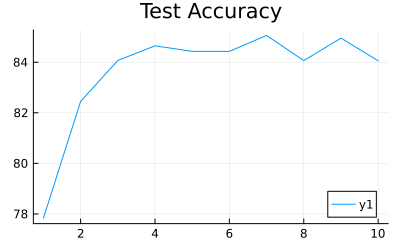

In [9]:
import Plots
Plots.gr(size=(400,250))
Plots.plot(accus, title="Test Accuracy")

정규화 순서 바꾸기

In [10]:
function (t::Transformer)(x::A, mask=nothing) where {T, N, A<:AbstractArray{T, N}}
    n = t.mhn(x)
    a = t.mh(n, n, n; mask=mask)
    x = x + t.drop(a)

    n = t.pwn(x)
    x + t.drop(t.pw(n))
end

In [11]:
model_base = build_model(num_words + 1 => embed_size, hs = 64)

models = [model_base] .|> Flux.gpu
losses, accus = run_batch((train_loader, test_loader), models, 10);

[Model 1] Epoch 1
-------------------------------


[Train] loss: 0.7219705 [100/547]


[Train] loss: 0.6384148 [200/547]


[Train] loss: 0.5808401 [300/547]


[Train] loss: 0.5399647 [400/547]


[Train] loss: 0.4161785 [500/547]


[Test] Accuracy: 78.1, Avg loss: 0.4766563
[Model 1] Epoch 2
-------------------------------


[Train] loss: 0.5407210 [100/547]


[Train] loss: 0.3884776 [200/547]


[Train] loss: 0.2824308 [300/547]


[Train] loss: 0.3488252 [400/547]


[Train] loss: 0.2716538 [500/547]


[Test] Accuracy: 83.6, Avg loss: 0.3950544
[Model 1] Epoch 3
-------------------------------


[Train] loss: 0.3284824 [100/547]


[Train] loss: 0.2837182 [200/547]


[Train] loss: 0.1404986 [300/547]


[Train] loss: 0.2680425 [400/547]


[Train] loss: 0.2088886 [500/547]


[Test] Accuracy: 84.7, Avg loss: 0.3644392
[Model 1] Epoch 4
-------------------------------


[Train] loss: 0.2519898 [100/547]


[Train] loss: 0.2326104 [200/547]


[Train] loss: 0.1107452 [300/547]


[Train] loss: 0.1822026 [400/547]


[Train] loss: 0.1147485 [500/547]


[Test] Accuracy: 85.1, Avg loss: 0.3822869
[Model 1] Epoch 5
-------------------------------


[Train] loss: 0.1660950 [100/547]


[Train] loss: 0.1355330 [200/547]


[Train] loss: 0.0857210 [300/547]


[Train] loss: 0.1293480 [400/547]


[Train] loss: 0.1093043 [500/547]


[Test] Accuracy: 85.5, Avg loss: 0.3870030
[Model 1] Epoch 6
-------------------------------


[Train] loss: 0.1297684 [100/547]


[Train] loss: 0.1257314 [200/547]


[Train] loss: 0.0599921 [300/547]


[Train] loss: 0.0472301 [400/547]


[Train] loss: 0.0840132 [500/547]


[Test] Accuracy: 86.1, Avg loss: 0.4685294
[Model 1] Epoch 7
-------------------------------


[Train] loss: 0.1253218 [100/547]


[Train] loss: 0.1284708 [200/547]


[Train] loss: 0.0585388 [300/547]


[Train] loss: 0.0486413 [400/547]


[Train] loss: 0.0639490 [500/547]


[Test] Accuracy: 85.2, Avg loss: 0.6533006
[Model 1] Epoch 8
-------------------------------


[Train] loss: 0.0994132 [100/547]


[Train] loss: 0.0832545 [200/547]


[Train] loss: 0.1150042 [300/547]


[Train] loss: 0.0508263 [400/547]


[Train] loss: 0.0403984 [500/547]


[Test] Accuracy: 85.7, Avg loss: 0.7701297
[Model 1] Epoch 9
-------------------------------


[Train] loss: 0.1191966 [100/547]


[Train] loss: 0.0339560 [200/547]


[Train] loss: 0.0852935 [300/547]


[Train] loss: 0.0789756 [400/547]


[Train] loss: 0.0689293 [500/547]


[Test] Accuracy: 86.2, Avg loss: 0.8593016
[Model 1] Epoch 10
-------------------------------


[Train] loss: 0.0377632 [100/547]


[Train] loss: 0.0357452 [200/547]


[Train] loss: 0.0084734 [300/547]


[Train] loss: 0.1220552 [400/547]


[Train] loss: 0.0275912 [500/547]


[Test] Accuracy: 86.0, Avg loss: 0.8782567


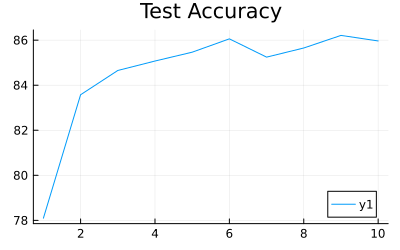

In [12]:
import Plots
Plots.gr(size=(400,250))
Plots.plot(accus, title="Test Accuracy")